In [8]:
import pandas as pd

# Load the dataset
df = pd.read_csv('sensor_data.csv')

# Parse timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Focus only on sensor features
features = ['temperature', 'humidity', 'air_quality', 'noise_level']
df_selected = df[features]

print(df_selected.head())



                                  temperature  humidity  air_quality  \
timestamp                                                              
2025-04-26 10:10:34.078000+00:00         33.1      73.8           89   
2025-04-26 10:11:35.697000+00:00         33.2      73.7          101   
2025-04-26 10:12:37.143000+00:00         33.2      73.7           65   
2025-04-26 10:13:38.812000+00:00         33.2      73.7           94   
2025-04-26 10:14:40.468000+00:00         33.2      73.9           95   

                                  noise_level  
timestamp                                      
2025-04-26 10:10:34.078000+00:00            3  
2025-04-26 10:11:35.697000+00:00            2  
2025-04-26 10:12:37.143000+00:00           28  
2025-04-26 10:13:38.812000+00:00            3  
2025-04-26 10:14:40.468000+00:00            9  


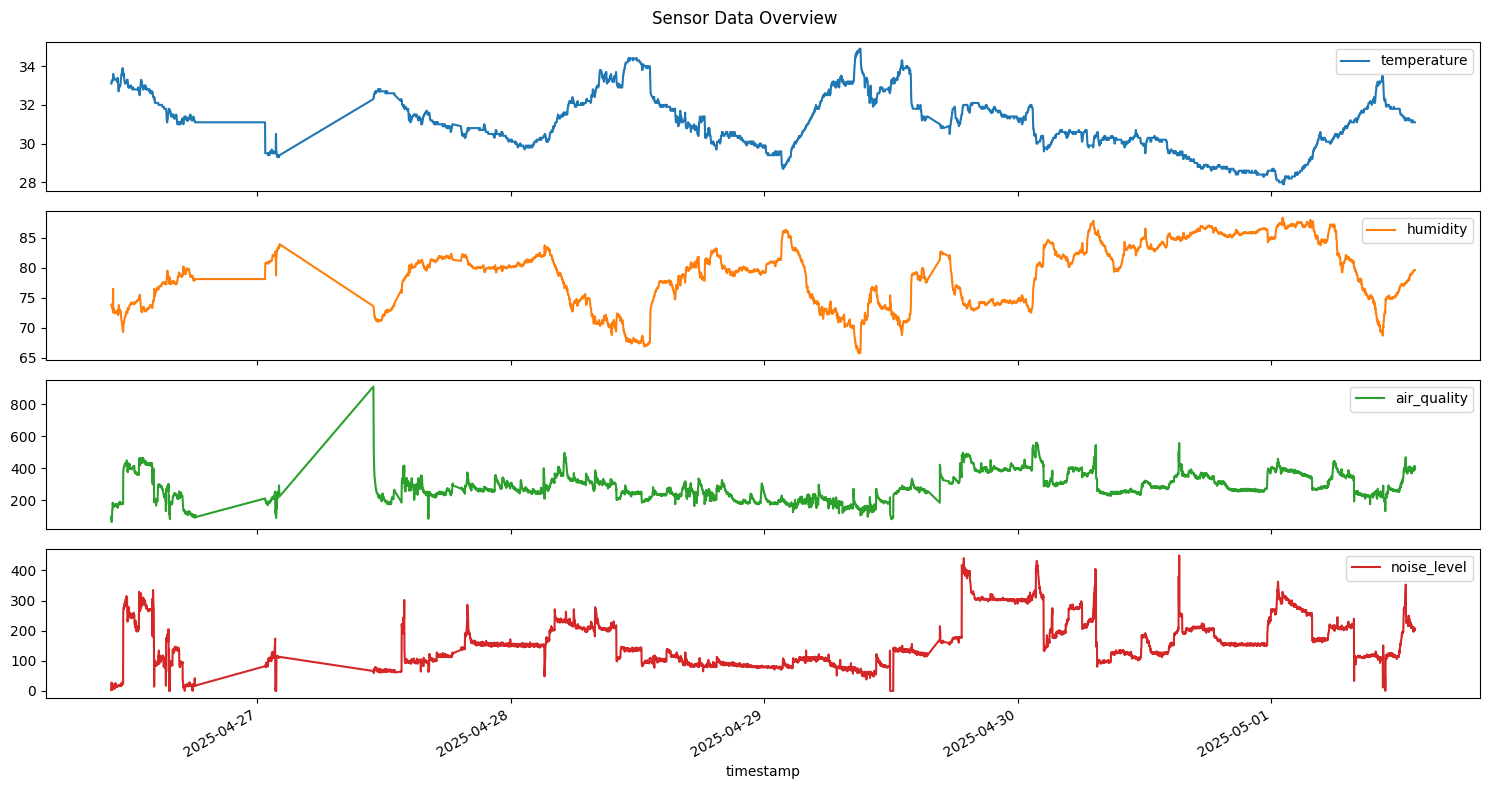

In [9]:
import matplotlib.pyplot as plt

df_selected.plot(figsize=(15,8), subplots=True, title='Sensor Data Overview')
plt.tight_layout()
plt.show()


In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f"{label} : {value}")
    if result[1] <= 0.05:
        print(" Strong evidence against the null hypothesis (Stationary)")
    else:
        print(" Weak evidence against null hypothesis (Non-stationary)")

# Apply to all features
for feature in features:
    adf_test(df_selected[feature], title=feature)
    print("\n")


Augmented Dickey-Fuller Test: temperature
ADF Test Statistic : -2.8054872991105273
p-value : 0.05749421142657081
# Lags Used : 23
Number of Observations Used : 6404
 Weak evidence against null hypothesis (Non-stationary)


Augmented Dickey-Fuller Test: humidity
ADF Test Statistic : -3.17032760348707
p-value : 0.021767770862531812
# Lags Used : 21
Number of Observations Used : 6406
 Strong evidence against the null hypothesis (Stationary)


Augmented Dickey-Fuller Test: air_quality
ADF Test Statistic : -4.4238506349477404
p-value : 0.0002692745697260224
# Lags Used : 24
Number of Observations Used : 6403
 Strong evidence against the null hypothesis (Stationary)


Augmented Dickey-Fuller Test: noise_level
ADF Test Statistic : -4.456158084748624
p-value : 0.00023579564251120907
# Lags Used : 18
Number of Observations Used : 6409
 Strong evidence against the null hypothesis (Stationary)




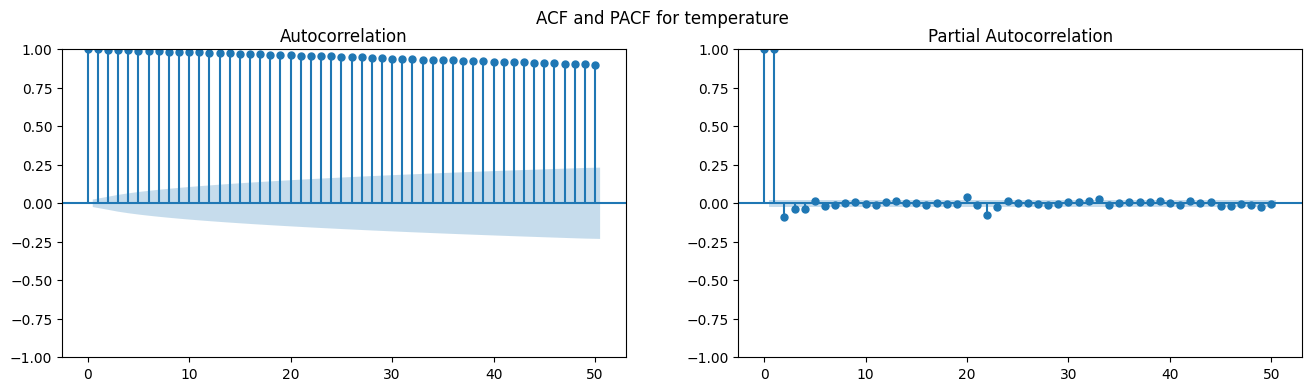

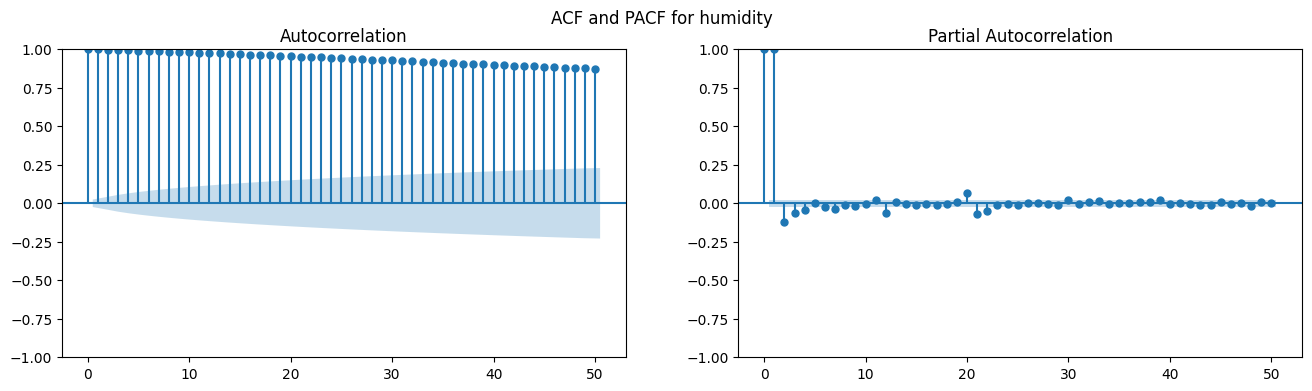

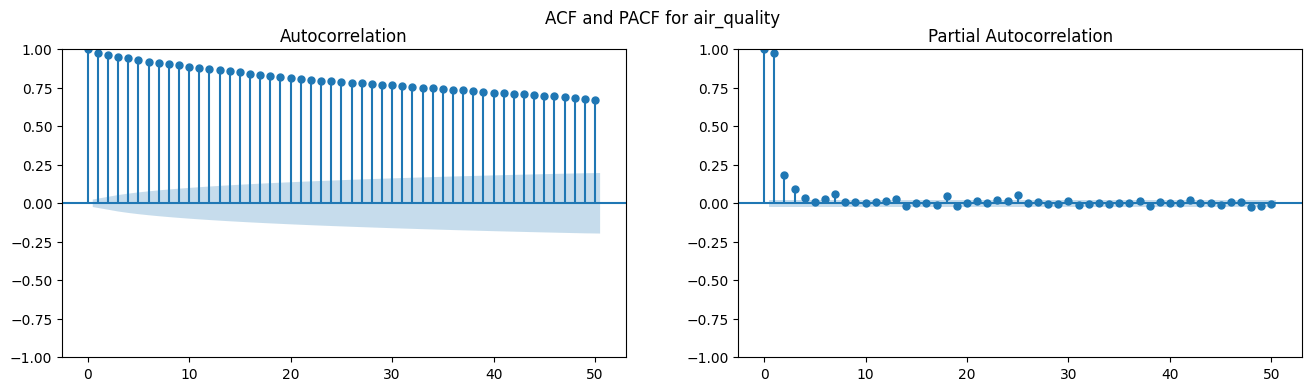

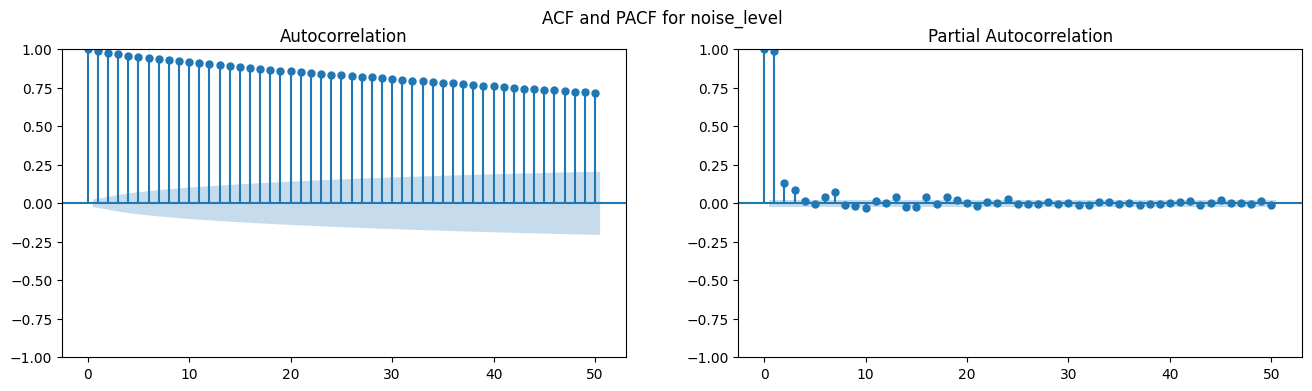

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for feature in features:
    fig, axes = plt.subplots(1, 2, figsize=(16,4))
    plot_acf(df_selected[feature].dropna(), ax=axes[0], lags=50)
    plot_pacf(df_selected[feature].dropna(), ax=axes[1], lags=50)
    fig.suptitle(f'ACF and PACF for {feature}')
    plt.show()


In [12]:
train_size = int(len(df_selected) * 0.8)
train = df_selected.iloc[:train_size]
test = df_selected.iloc[train_size:]


In [13]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

predictions = {}

for feature in features:
    print(f"\n🔵 Building SARIMA model for {feature}")

    stepwise_model = auto_arima(train[feature],
                                seasonal=True,
                                m=144,  # Assume daily cycle (144 steps if 10min data)
                                suppress_warnings=True,
                                trace=True,
                                error_action='ignore')

    model = SARIMAX(train[feature],
                    order=stepwise_model.order,
                    seasonal_order=stepwise_model.seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    pred = model_fit.forecast(steps=len(test))
    predictions[feature] = pred

print("\n✅ All Features Forecasted!")



🔵 Building SARIMA model for temperature
Performing stepwise search to minimize aic


KeyboardInterrupt: 

KeyError: 'temperature'

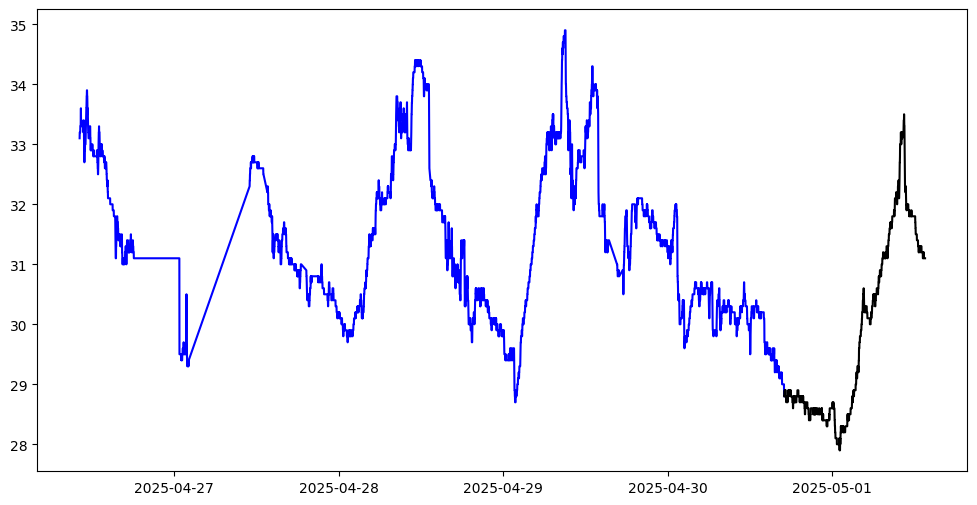

In [ ]:
for feature in features:
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train[feature], label='Train', color='blue')
    plt.plot(test.index, test[feature], label='Actual Test', color='black')
    plt.plot(test.index, predictions[feature], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {feature.capitalize()}')
    plt.xlabel('Timestamp')
    plt.ylabel(feature.capitalize())
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

for feature in features:
    mse = mean_squared_error(test[feature], predictions[feature])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test[feature], predictions[feature])
    
    print(f"\n📈 Evaluation for {feature}:")
    print(f"   - MAE: {mae:.4f}")
    print(f"   - RMSE: {rmse:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
df = pd.read_csv('sensor_data.csv')

# Parse datetime
df['local_timestamp'] = pd.to_datetime(df['local_timestamp'])
df.set_index('local_timestamp', inplace=True)

# Sort
df = df.sort_index()

# Select features
features = ['temperature', 'humidity', 'air_quality', 'noise_level']
df_selected = df[features]

print(df_selected.head())


                                  temperature  humidity  air_quality  \
local_timestamp                                                        
2025-04-26 15:44:40.468000+00:00         33.2      73.9           95   
2025-04-26 15:45:42.112000+00:00         33.2      73.7          135   
2025-04-26 15:46:43.533000+00:00         33.3      73.3          144   
2025-04-26 15:47:45.387000+00:00         33.3      73.2          144   
2025-04-26 15:48:47.026000+00:00         33.3      73.1          185   

                                  noise_level  
local_timestamp                                
2025-04-26 15:44:40.468000+00:00            9  
2025-04-26 15:45:42.112000+00:00           12  
2025-04-26 15:46:43.533000+00:00           13  
2025-04-26 15:47:45.387000+00:00            9  
2025-04-26 15:48:47.026000+00:00           12  


In [ ]:
# First check stationarity already done (ADF)

# Apply differencing to non-stationary features
df_selected['temperature_diff'] = df_selected['temperature'].diff()
df_selected['humidity_diff'] = df_selected['humidity'].diff()

# Drop NA rows created by differencing
df_selected = df_selected.dropna()

print(df_selected.head())


                                  temperature  humidity  air_quality  \
local_timestamp                                                        
2025-04-26 15:45:42.112000+00:00         33.2      73.7          135   
2025-04-26 15:46:43.533000+00:00         33.3      73.3          144   
2025-04-26 15:47:45.387000+00:00         33.3      73.2          144   
2025-04-26 15:48:47.026000+00:00         33.3      73.1          185   
2025-04-26 15:49:48.696000+00:00         33.3      73.6          169   

                                  noise_level  temperature_diff  humidity_diff  
local_timestamp                                                                 
2025-04-26 15:45:42.112000+00:00           12               0.0           -0.2  
2025-04-26 15:46:43.533000+00:00           13               0.1           -0.4  
2025-04-26 15:47:45.387000+00:00            9               0.0           -0.1  
2025-04-26 15:48:47.026000+00:00           12               0.0           -0.1  
2025-04-2

C:\Users\94772\AppData\Local\Temp\ipykernel_13976\3113551300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['temperature_diff'] = df_selected['temperature'].diff()
C:\Users\94772\AppData\Local\Temp\ipykernel_13976\3113551300.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['humidity_diff'] = df_selected['humidity'].diff()


In [ ]:
# 80% train, 20% test
train_size = int(0.8 * len(df_selected))
train, test = df_selected.iloc[:train_size], df_selected.iloc[train_size:]

# How many samples?
print('Train samples:', len(train))
print('Test samples:', len(test))


Train samples: 1184
Test samples: 297


In [ ]:
def train_sarima(train_data, test_data, order, seasonal_order, feature_name, differenced=False):
    print(f"\n Training model for {feature_name}...")

    model = SARIMAX(
        train_data,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    results = model.fit(disp=False)

    # Forecast
    pred = results.get_forecast(steps=len(test_data))
    pred_mean = pred.predicted_mean

    # Reverse differencing if needed
    if differenced:
        pred_mean = pred_mean.cumsum() + train[feature_name].iloc[-1]

    #  FIX 1: Drop NaNs from test data
    test_data_clean = test_data.dropna()
    pred_mean_clean = pred_mean[:len(test_data_clean)]

    #  FIX 2: Reset index for plotting
    actual_values = test_data_clean.values
    predicted_values = pred_mean_clean.values
    x_axis = np.arange(len(actual_values))  # just integers 0,1,2,...

    # Evaluation
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    r2 = r2_score(actual_values, predicted_values)
    
    print(f" {feature_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(x_axis, actual_values, label='Actual')
    plt.plot(x_axis, predicted_values, label='Forecast', linestyle='--')
    plt.title(f'{feature_name.capitalize()} - Actual vs Forecast')
    plt.xlabel('Sample Index')
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid()
    plt.show()
    
    return results, pred_mean



🚀 Training model for temperature...


c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

✅ temperature - MAE: 30.3915, RMSE: 30.3917, R2: -77632.4849


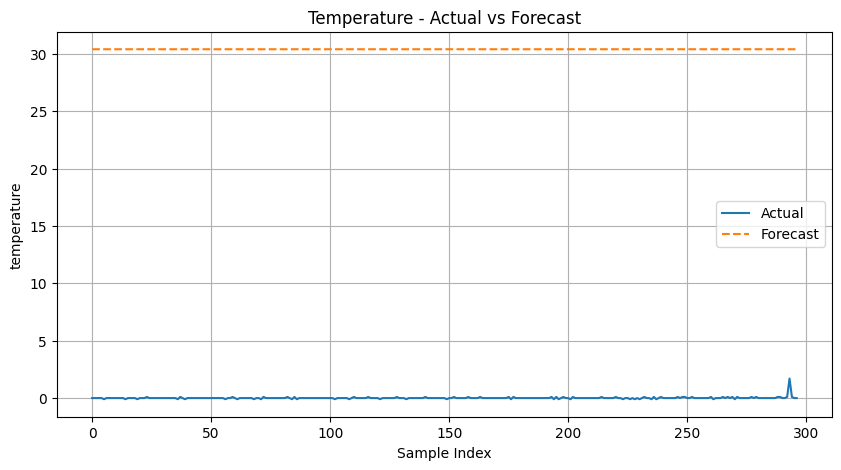


🚀 Training model for humidity...


c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

✅ humidity - MAE: 80.0220, RMSE: 80.0228, R2: -50666.7641


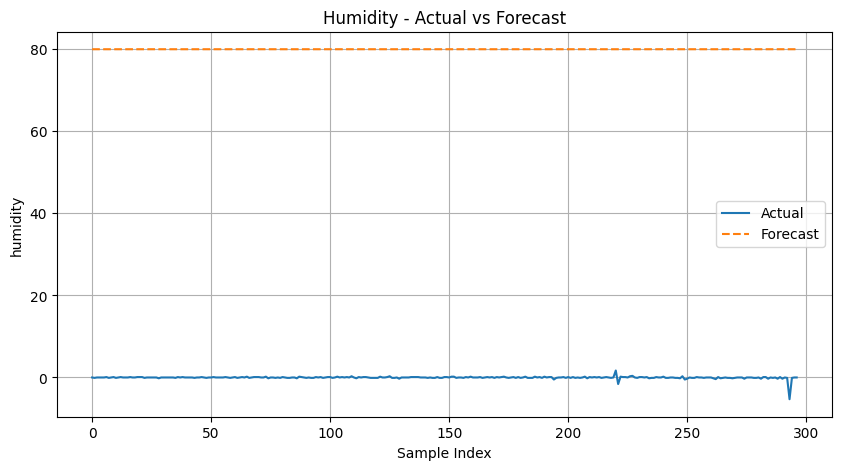


🚀 Training model for air_quality...


c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

✅ air_quality - MAE: 81.4562, RMSE: 104.6178, R2: -6.1091


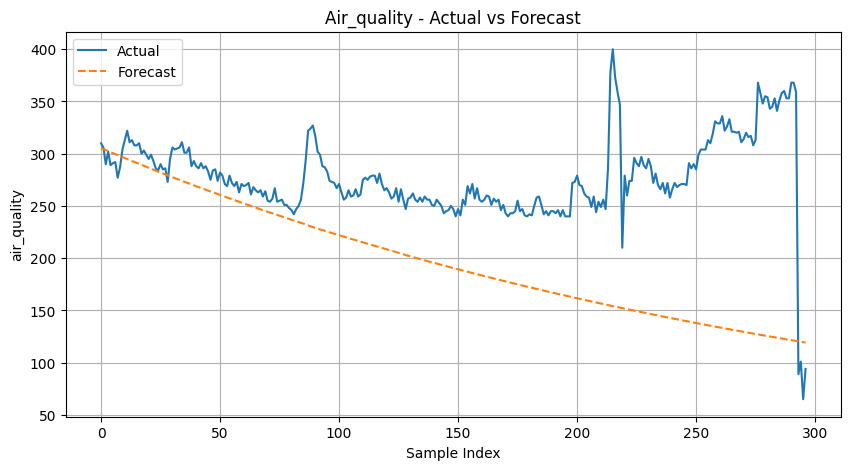


🚀 Training model for noise_level...


c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

✅ noise_level - MAE: 90.5811, RMSE: 105.2329, R2: -9.3153


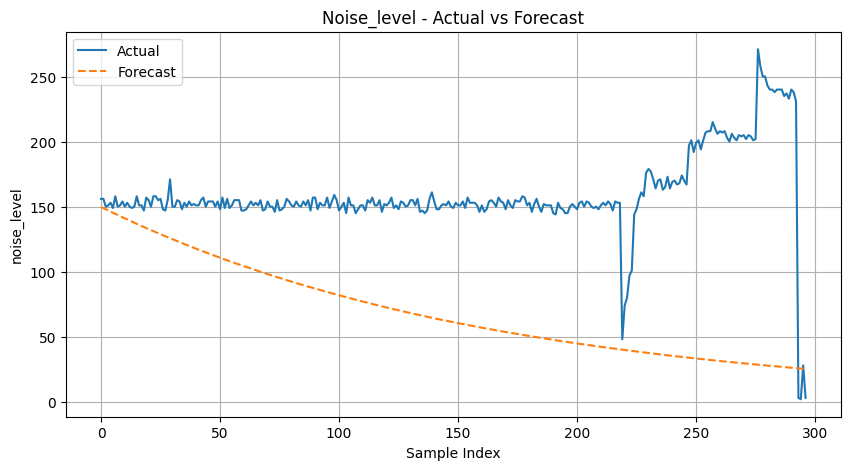

In [ ]:
# Temperature
temp_model, temp_forecast = train_sarima(
    train['temperature_diff'], test['temperature_diff'],
    order=(1,0,1), seasonal_order=(1,0,1,144),
    feature_name='temperature', differenced=True
)

# Humidity
humidity_model, humidity_forecast = train_sarima(
    train['humidity_diff'], test['humidity_diff'],
    order=(1,0,1), seasonal_order=(1,0,1,144),
    feature_name='humidity', differenced=True
)

# Air Quality
airq_model, airq_forecast = train_sarima(
    train['air_quality'], test['air_quality'],
    order=(1,0,1), seasonal_order=(1,0,0,144),
    feature_name='air_quality', differenced=False
)

# Noise Level
noise_model, noise_forecast = train_sarima(
    train['noise_level'], test['noise_level'],
    order=(1,0,1), seasonal_order=(1,0,0,144),
    feature_name='noise_level', differenced=False
)


In [ ]:
# Predict 144 steps (1 day ahead) for each feature

future_steps = 144

future_temp_forecast = temp_model.get_forecast(steps=future_steps).predicted_mean
future_temp_forecast = future_temp_forecast.cumsum() + df_selected['temperature'].iloc[-1]

future_humidity_forecast = humidity_model.get_forecast(steps=future_steps).predicted_mean
future_humidity_forecast = future_humidity_forecast.cumsum() + df_selected['humidity'].iloc[-1]

future_airq_forecast = airq_model.get_forecast(steps=future_steps).predicted_mean
future_noise_forecast = noise_model.get_forecast(steps=future_steps).predicted_mean

# Build future datetime index
last_timestamp = df_selected.index[-1]
future_dates = pd.date_range(start=last_timestamp + pd.Timedelta(minutes=10), periods=future_steps, freq='10T')

# Plotting future forecast
plt.figure(figsize=(14,7))
plt.plot(future_dates, future_temp_forecast, label='Temperature Forecast')
plt.plot(future_dates, future_humidity_forecast, label='Humidity Forecast')
plt.plot(future_dates, future_airq_forecast, label='Air Quality Forecast')
plt.plot(future_dates, future_noise_forecast, label='Noise Level Forecast')
plt.title('🔮 1-Day Ahead Forecast (10-minute intervals)')
plt.xlabel('DateTime')
plt.ylabel('Sensor Values')
plt.legend()
plt.grid()
plt.show()


c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\94772\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Predictio

ValueError: Neither `start` nor `end` can be NaT